In [1]:
# Copyright (c) Facebook, Inc. and its affiliates.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# KubeFlow Pipelines :  Pytorch Cifar10 Image classification

This notebook shows PyTorch CIFAR10 end-to-end  classification example using Kubeflow Pipelines. 

An example notebook that demonstrates how to:

* Get different tasks needed for the pipeline
* Create a Kubeflow pipeline
* Include Pytorch KFP components to preprocess, train, visualize and deploy the model in the pipeline
* Submit a job for execution
* Query(prediction and explain) the final deployed model
* Interpretation of the model using the Captum Insights


## import the necessary packages

In [22]:
import kfp
import json
import os
from kfp.onprem import use_k8s_secret
from kfp import components
from kfp.components import load_component_from_file, load_component_from_url
from kfp import dsl
from kfp import compiler

import numpy as np
import logging


kfp.__version__

# Enter your gateway and the auth token
[Use this extension on chrome to get token]( https://chrome.google.com/webstore/detail/editthiscookie/fngmhnnpilhplaeedifhccceomclgfbg?hl=en)

![image.png](./image.png)

## Update values for the ingress gateway and auth session

In [14]:
INGRESS_GATEWAY='http://istio-ingressgateway.istio-system.svc.cluster.local'
AUTH="<enter your auth token>"
NAMESPACE="kubeflow-user-example-com"
COOKIE="authservice_session="+AUTH
EXPERIMENT="Default"

## Set  the Log bucket and Tensorboard Image

In [15]:
MINIO_ENDPOINT="http://minio-service.kubeflow:9000"
LOG_BUCKET="mlpipeline"
TENSORBOARD_IMAGE="public.ecr.aws/y1x1p2u5/tboard:latest"

## Set the client and create the experiment

In [16]:
client = kfp.Client(host=INGRESS_GATEWAY+"/pipeline", cookies=COOKIE)

In [17]:
client.create_experiment(EXPERIMENT)
experiments = client.list_experiments(namespace=NAMESPACE)
my_experiment = experiments.experiments[0]
my_experiment

{'created_at': datetime.datetime(2021, 4, 22, 8, 44, 39, tzinfo=tzlocal()),
 'description': None,
 'id': 'aac96a63-616e-4d88-9334-6ca8df2bb956',
 'name': 'Default',
 'resource_references': [{'key': {'id': 'kubeflow-user-example-com',
                                  'type': 'NAMESPACE'},
                          'name': None,
                          'relationship': 'OWNER'}],
 'storage_state': 'STORAGESTATE_AVAILABLE'}

## Set  the Inference parameters

In [18]:
DEPLOY_NAME="torchserve"
MODEL_NAME="cifar10"
ISVC_NAME=DEPLOY_NAME+"."+NAMESPACE+"."+"example.com"
INPUT_REQUEST="https://raw.githubusercontent.com/kubeflow/pipelines/master/samples/contrib/pytorch-samples/cifar10/input.json"

## Load the the components yaml files for setting up the components

In [19]:
prepare_tensorboard_op = load_component_from_file("./common/tensorboard/component.yaml")
prep_op = components.load_component_from_file(
    "./cifar10/yaml/pre_process/component.yaml"
)
train_op = components.load_component_from_file(
    "./cifar10/yaml/train/component.yaml"
)
deploy_op = load_component_from_file("./common/deploy/component.yaml")
pred_op = load_component_from_file("./common/prediction/component.yaml")
minio_op = components.load_component_from_file(
    "./common/minio/component.yaml"
)


## Define the pipeline

In [20]:

@dsl.pipeline(name="Training Cifar10 pipeline", description="Cifar 10 dataset pipeline")
def pytorch_cifar10(
    minio_endpoint=MINIO_ENDPOINT,
    log_bucket=LOG_BUCKET,
    log_dir=f"tensorboard/logs/{dsl.RUN_ID_PLACEHOLDER}",
    mar_path=f"mar/{dsl.RUN_ID_PLACEHOLDER}/model-store",
    config_prop_path=f"mar/{dsl.RUN_ID_PLACEHOLDER}/config",
    model_uri=f"s3://mlpipeline/mar/{dsl.RUN_ID_PLACEHOLDER}",
    tf_image=TENSORBOARD_IMAGE,
    deploy=DEPLOY_NAME,
    isvc_name=ISVC_NAME,
    model=MODEL_NAME,
    namespace=NAMESPACE,
    confusion_matrix_log_dir=f"confusion_matrix/{dsl.RUN_ID_PLACEHOLDER}/",
    checkpoint_dir=f"checkpoint_dir/cifar10",
    input_req=INPUT_REQUEST,
    cookie=COOKIE,
    ingress_gateway=INGRESS_GATEWAY
):
    pod_template_spec = json.dumps(
        {
            "spec": {
                "containers": [
                    {
                        "env": [
                            {
                                "name": "AWS_ACCESS_KEY_ID",
                                "valueFrom": {
                                    "secretKeyRef": {
                                        "name": "mlpipeline-minio-artifact",
                                        "key": "accesskey",
                                    }
                                },
                            },
                            {
                                "name": "AWS_SECRET_ACCESS_KEY",
                                "valueFrom": {
                                    "secretKeyRef": {
                                        "name": "mlpipeline-minio-artifact",
                                        "key": "secretkey",
                                    }
                                },
                            },
                            {"name": "AWS_REGION", "value": "minio"},
                            {"name": "S3_ENDPOINT", "value": f"{minio_endpoint}"},
                            {"name": "S3_USE_HTTPS", "value": "0"},
                            {"name": "S3_VERIFY_SSL", "value": "0"},
                        ]
                    }
                ]
            }
        }
    )

    prepare_tb_task = prepare_tensorboard_op(
        log_dir_uri=f"s3://{log_bucket}/{log_dir}",
        image=tf_image,
        pod_template_spec=pod_template_spec,
    ).set_display_name("Visualization")

    prep_task = prep_op().after(prepare_tb_task).set_display_name("Preprocess & Transform")
    train_task = (
        train_op(
            input_data=prep_task.outputs["output_data"],
            profiler="pytorch",
            confusion_matrix_url=f"minio://{log_bucket}/{confusion_matrix_log_dir}",
            # For GPU set gpu count and accelerator type
            gpus=0,
            accelerator='None'
        )
        .after(prep_task)
        .set_display_name("Training")
    )
    # For GPU uncomment below line and set GPU limit and node selector
    # ).set_gpu_limit(1).add_node_selector_constraint('cloud.google.com/gke-accelerator','nvidia-tesla-p4')

    minio_tb_upload = (
        minio_op(
            bucket_name="mlpipeline",
            folder_name=log_dir,
            input_path=train_task.outputs["tensorboard_root"],
            filename="",
        )
        .after(train_task)
        .set_display_name("Tensorboard Events Pusher")
    )

    minio_checkpoint_dir_upload = (
        minio_op(
            bucket_name="mlpipeline",
            folder_name=checkpoint_dir,
            input_path=train_task.outputs["checkpoint_dir"],
            filename="",
        )
        .after(train_task)
        .set_display_name("checkpoint_dir Pusher")
    )

    minio_mar_upload = (
        minio_op(
            bucket_name="mlpipeline",
            folder_name=mar_path,
            input_path=train_task.outputs["checkpoint_dir"],
            filename="cifar10_test.mar",
        )
        .after(train_task)
        .set_display_name("Mar Pusher")
    )
    
    minio_config_upload = (
        minio_op(
            bucket_name="mlpipeline",
            folder_name=config_prop_path,
            input_path=train_task.outputs["checkpoint_dir"],
            filename="config.properties",
        )
        .after(train_task)
        .set_display_name("Conifg Pusher")
    )

    model_uri = str(model_uri)
    isvc_yaml = """
    apiVersion: "serving.kubeflow.org/v1beta1"
    kind: "InferenceService"
    metadata:
      name: {}
      namespace: {}
    spec:
      predictor:
        serviceAccountName: sa
        pytorch:
          storageUri: {}
          resources:
            requests: 
              cpu: 4
              memory: 16Gi
            limits:
              cpu: 4
              memory: 16Gi
    """.format(
        deploy, namespace, model_uri
    )
    
    # For GPU inference use below yaml with gpu count and accelerator
    gpu_count = "1"
    accelerator = "nvidia-tesla-p4"
    isvc_gpu_yaml = """
    apiVersion: "serving.kubeflow.org/v1beta1"
    kind: "InferenceService"
    metadata:
      name: {}
      namespace: {}
    spec:
      predictor:
        serviceAccountName: sa
        pytorch:
          storageUri: {}
          resources:
            limits:
              memory: 4Gi   
              nvidia.com/gpu: {}
          nodeSelector:
            cloud.google.com/gke-accelerator: {}
""".format(
        deploy, namespace, model_uri, gpu_count, accelerator
    )
    # Update inferenceservice_yaml for GPU inference
    deploy_task = (
        deploy_op(action="apply", inferenceservice_yaml=isvc_yaml)
        .after(minio_mar_upload)
        .set_display_name("Deployer")
    )
    pred_task = (
        pred_op(
            host_name=ISVC_NAME,
            input_request=INPUT_REQUEST,
            cookie=COOKIE,
            url=INGRESS_GATEWAY,
            model=MODEL_NAME,
            inference_type="predict",
        )
        .after(deploy_task)
        .set_display_name("Prediction")
    )
    explain_task = (
        pred_op(
            host_name=ISVC_NAME,
            input_request=INPUT_REQUEST,
            cookie=COOKIE,
            url=INGRESS_GATEWAY,
            model=MODEL_NAME,
            inference_type="explain",
        )
        .after(pred_task)
        .set_display_name("Explanation")
    )
    
    dsl.get_pipeline_conf().add_op_transformer(
        use_k8s_secret(
            secret_name="mlpipeline-minio-artifact",
            k8s_secret_key_to_env={
                "secretkey": "MINIO_SECRET_KEY",
                "accesskey": "MINIO_ACCESS_KEY",
            },
        )
    )

## Compile the pipeline

In [21]:
compiler.Compiler().compile(pytorch_cifar10, 'pytorch.tar.gz', type_check=True)

##  Execute the pipeline

In [22]:
run = client.run_pipeline(my_experiment.id, 'pytorch-cifar10', 'pytorch.tar.gz')

## Wait for inference service below to go to READY True state

In [ ]:
!kubectl get isvc $DEPLOY

## Get  the Inference service name

In [32]:
INFERENCE_SERVICE_LIST = ! kubectl get isvc {DEPLOY_NAME} -n {NAMESPACE} -o json | python3 -c "import sys, json; print(json.load(sys.stdin)['status']['url'])"| tr -d '"' | cut -d "/" -f 3
INFERENCE_SERVICE_NAME = INFERENCE_SERVICE_LIST[0]
INFERENCE_SERVICE_NAME

'torchserve.kubeflow-user-example-com.example.com'

## Use the deployed model for prediction request and save the output into a json

In [21]:
!curl -v -H "Host: $INFERENCE_SERVICE_NAME" -H "Cookie: $COOKIE" "$INGRESS_GATEWAY/v1/models/$MODEL_NAME:predict" -d @./cifar10/input.json > cifar10_prediction_output.json

In [25]:
! cat cifar10_prediction_output.json

{"predictions": [{"1": 0.46885740756988525, "9": 0.36460113525390625, "6": 0.0706615149974823, "0": 0.047263678163290024, "8": 0.020805558189749718}]}

## Use the deployed model for explain request and save the output into a json

In [20]:
!curl -v -H "Host: $INFERENCE_SERVICE_NAME" -H "Cookie: $COOKIE" "$INGRESS_GATEWAY/v1/models/$MODEL_NAME:explain" -d @./cifar10/input.json > cifar10_explanation_output.json

## Model Interpretation using Captum Vis and Insights

#### Install dependencies for Captum Insights

In [3]:
!./install-dependencies.sh

##### import the necessary packages

In [1]:
from PIL import Image
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import torchvision.transforms as transforms
import torch
import torch.nn.functional as F
import json
import captum
from captum.attr import LayerAttribution
from captum.attr import visualization as viz

##### Read the prediction, explanation, and the class mapping file which saved during the prediction and expalain requests.

In [2]:
# prediction_json = json.loads(open("./cifar10_prediction_output.json", "r").read())

explainations_json = json.loads(open("./cifar10/cifar10_explanation_output.json", "r").read())

labels_path = './cifar10/class_mapping.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data) 

##### Define some transfomration to apply on the input test images

In [3]:
# model expects 224x224 3-color image
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

#### Read the input test image

In [4]:
test_img = Image.open('./cifar10/kitten.png')
test_img_data = np.asarray(test_img)

#### Apply the transformations on the input test image and the explainations json

In [5]:

attributions= explainations_json["explanations"]
attributions_ig=attributions[0]["attributions_ig"]
attributions_ig = np.array(attributions_ig)
attributions_ig = attributions_ig.reshape((224,224,3))



attributions_lgc=attributions[1]["attributions_lgc"]
attributions_lgc = np.array(attributions_lgc)
attributions_lgc = torch.tensor(attributions_lgc)

attributions_occ=attributions[2]["attributions_occ"]
attributions_occ = np.array(attributions_occ)


transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

##### Define the minio client for downloading the artifactes from minio storage ( model pth file and training file)

In [41]:
from minio import Minio
from kubernetes import client, config
import base64

config.load_incluster_config()
v1 = client.CoreV1Api()
sec = v1.read_namespaced_secret("mlpipeline-minio-artifact", NAMESPACE).data
minio_accesskey = base64.b64decode(sec["accesskey"]).decode('UTF-8')
minio_secretkey = base64.b64decode(sec["secretkey"]).decode('UTF-8')


minio_config = {
            "HOST": "minio-service.kubeflow:9000",
            "ACCESS_KEY": minio_accesskey,
            "SECRET_KEY": minio_secretkey,
            "BUCKET": "mlpipeline",
            "FOLDER": "checkpoint_dir/cifar10"}

def _initiate_minio_client(minio_config):
        minio_host = minio_config["HOST"]
        access_key = minio_config["ACCESS_KEY"]
        secret_key = minio_config["SECRET_KEY"]
        client = Minio(minio_host, access_key=access_key, secret_key=secret_key, secure=False)
        return client

client= _initiate_minio_client(minio_config)
client

In [42]:
def download_artifact_from_minio(folder: str, artifact: str):
        artifact_name = artifact.split("/")[-1]
        result = client.fget_object(
            minio_config["BUCKET"],
            os.path.join(folder, artifact_name),
            artifact,
        )

In [19]:
download_artifact_from_minio(minio_config["FOLDER"],"resnet.pth")
print("[INFO] Downloaded the Model Pth File.....")
download_artifact_from_minio(minio_config["FOLDER"],"cifar10_train.py")
print("[INFO] Downloaded the Model Classifier File.....")

#### Load the downloaded model pth file and classifer

In [18]:
from cifar10_train import CIFAR10Classifier
model = CIFAR10Classifier()

model_pt_path ="./resnet.pth"
model.load_state_dict(torch.load(model_pt_path,map_location=torch.device('cpu')))
model.eval()

####  Captum visualization for input image and explain response 

#####  Integrated Gradients Vis

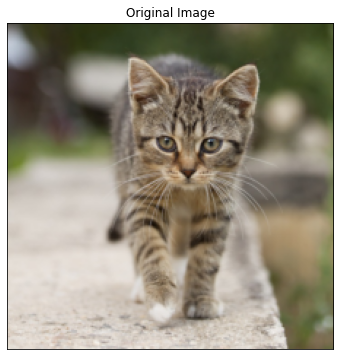

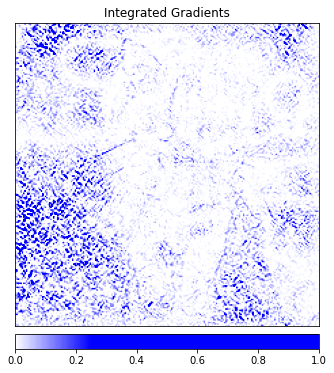

In [6]:
# Show the original image for comparison
_ = viz.visualize_image_attr(None, np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)), 
                      method="original_image", title="Original Image")

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(attributions_ig,
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

##### LayerGradCam Vis

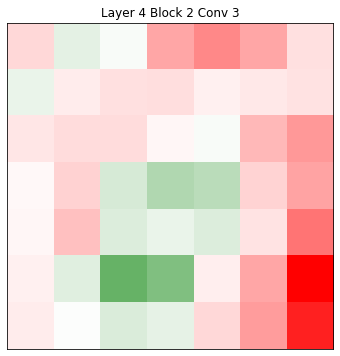

In [7]:
_ = viz.visualize_image_attr(attributions_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                             sign="all",
                             title="Layer 4 Block 2 Conv 3")

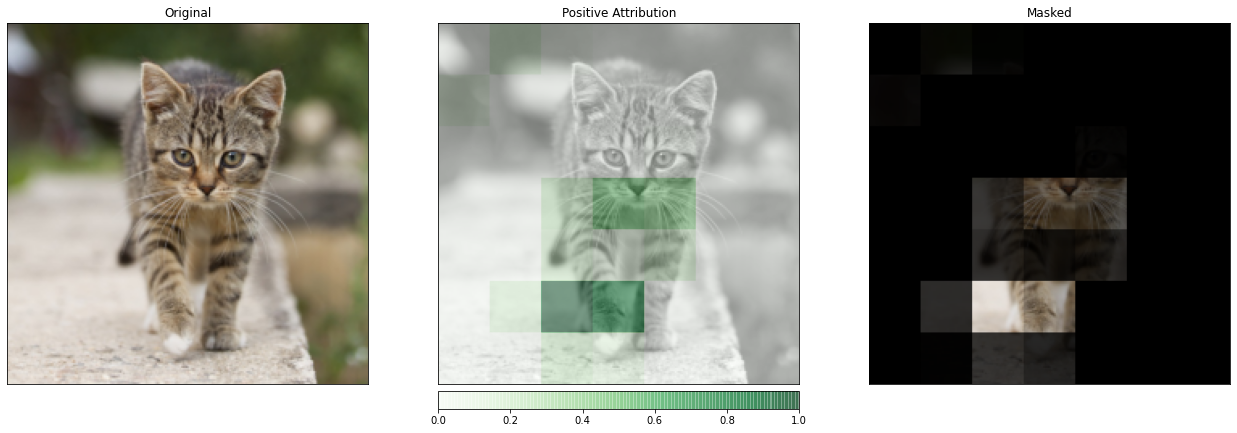

In [8]:
upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input_img.shape[2:])
_ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      transformed_img.permute(1,2,0).numpy(),
                                      ["original_image","blended_heat_map","masked_image"],
                                      ["all","positive","positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Masked"],
                                      fig_size=(18, 6))

##### Occlusion Vis

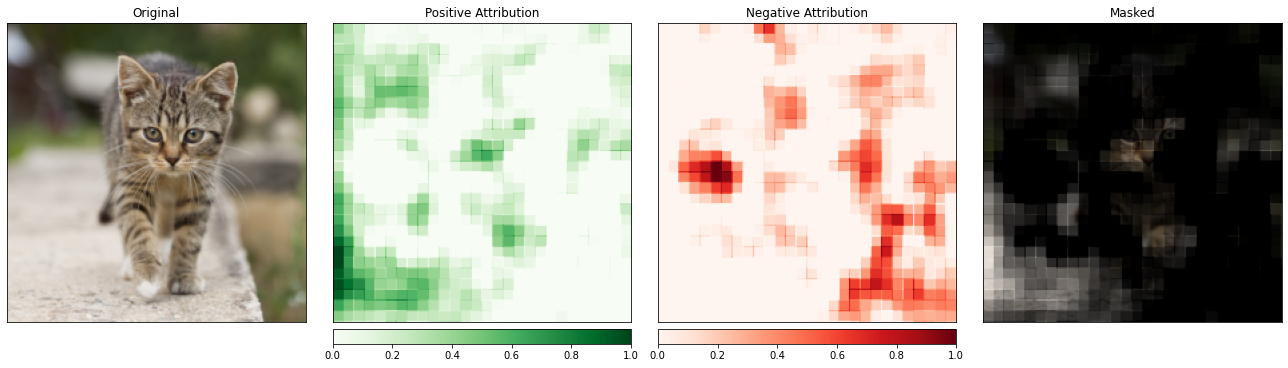

In [9]:
_ = viz.visualize_image_attr_multiple(attributions_occ,
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6)
                                     )

##### Captum Insights can also be used for visualization

In [39]:
#Lets read two test images and make the prediction and use these images for captum Insights. 

imgs = ['./cifar10/kitten.png',"./cifar10/horse.png"]

for img in imgs:
    img = Image.open(img)
    transformed_img = transform(img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

    output = model(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[str(pred_label_idx.squeeze_().item())]
    print('Predicted:', predicted_label, '/', pred_label_idx.item(), ' (', prediction_score.squeeze().item(), ')')

In [48]:
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

# Baseline is all-zeros input - this may differ depending on your data
def baseline_func(input):
    return input * 0

# merging our image transforms from above
def full_img_transform(input):
    i = Image.open(input)
    i = transform(i)
    i = transform_normalize(i)
    i = i.unsqueeze(0)
    i.requires_grad = True
    return i


input_imgs = torch.cat(list(map(lambda i: full_img_transform(i), imgs)), 0)

visualizer = AttributionVisualizer(
    models=[model],
    score_func=lambda o: torch.nn.functional.softmax(o, 1),
    classes=list(map(lambda k: idx_to_labels[k], idx_to_labels.keys())),
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
            input_transforms=[],
        )
    ],
    dataset=[Batch(input_imgs, labels=[3,7])]
)

In [50]:
visualizer.serve(debug=True,port=6080)


Fetch data and view Captum Insights at http://localhost:6080/



6080

 * Debugger is active!
 * Debugger PIN: 109-049-484
 * Running on http://127.0.0.1:6080/ (Press CTRL+C to quit)


#### Captum Insights output image 

![CIFAR10_Captum_Insights](./cifar10/CIFAR10_Captum_Insights.png)

## Clean up
### Delete Viewers, Inference Services and Completed pods

In [56]:
! kubectl delete --all isvc -n $NAMESPACE

In [ ]:
! kubectl delete pod --field-selector=status.phase==Succeeded -n $NAMESPACE